# all questions solutions

In [1]:
# load modules

from pyspark.sql import SparkSession, functions as F
from pyspark.sql.functions import col
from pyspark.sql.window import Window

spark = SparkSession\
            .builder\
            .appName('AllSolutionsPujan')\
            .config('spark.driver.extraClassPath', '/usr/lib/jvm/java-19-openjdk/lib/postgresql-42.5.0.jar')\
            .getOrCreate()

22/11/04 12:46:14 WARN Utils: Your hostname, tars resolves to a loopback address: 127.0.1.1; using 192.168.1.66 instead (on interface wlan0)
22/11/04 12:46:14 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/11/04 12:46:15 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [2]:
# load weather data
weather_df = spark\
                .read\
                .option('inferSchema', 'true')\
                .option('header', 'true')\
                .csv('../cleaned_data/cleaned_weather_data.csv')

weather_df.cache().show(10)
weather_df.printSchema()

+-------------------+--------+-------+---------+---------+----+----+----+----+------+
|               date| country|   city| Latitude|Longitude|tavg|tmin|tmax|wspd|  pres|
+-------------------+--------+-------+---------+---------+----+----+----+----+------+
|2018-07-21 00:00:00|Abkhazia|Sukhumi|43.001525|41.023415|23.4|20.9|25.5| 9.3|1009.6|
|2018-07-22 00:00:00|Abkhazia|Sukhumi|43.001525|41.023415|23.5|21.0|25.7| 9.4|1010.0|
|2018-07-23 00:00:00|Abkhazia|Sukhumi|43.001525|41.023415|23.5|21.1|25.5| 8.2|1007.7|
|2018-07-24 00:00:00|Abkhazia|Sukhumi|43.001525|41.023415|24.3|20.8|27.1| 9.3|1004.4|
|2018-07-25 00:00:00|Abkhazia|Sukhumi|43.001525|41.023415|26.5|22.7|30.0| 9.7|1002.0|
|2018-07-26 00:00:00|Abkhazia|Sukhumi|43.001525|41.023415|26.7|24.6|28.7| 9.8|1006.7|
|2018-07-27 00:00:00|Abkhazia|Sukhumi|43.001525|41.023415|26.5|24.6|28.1| 8.4|1009.1|
|2018-07-28 00:00:00|Abkhazia|Sukhumi|43.001525|41.023415|26.4|24.5|28.2| 8.6|1007.5|
|2018-07-29 00:00:00|Abkhazia|Sukhumi|43.001525|41.023

In [3]:
# load continents data

continents_df = spark\
                    .read\
                    .option('inferSchema', 'true')\
                    .option('header', 'true')\
                    .csv('../cleaned_data/cleaned_country_continent.csv')

continents_df.cache().show(10)
continents_df.printSchema()

+-------------------+---------+
|            country|continent|
+-------------------+---------+
|        Afghanistan|     Asia|
|      �land Islands|   Europe|
|            Albania|   Europe|
|            Algeria|   Africa|
|     American Samoa|  Oceania|
|            Andorra|   Europe|
|             Angola|   Africa|
|           Anguilla| Americas|
|Antigua and Barbuda| Americas|
|          Argentina| Americas|
+-------------------+---------+
only showing top 10 rows

root
 |-- country: string (nullable = true)
 |-- continent: string (nullable = true)



## Qn. 1. Find the global average temperature each year. Is it increasing ?

In [4]:
global_avg_temp_df = weather_df\
        .groupBy(F.year('date').cast('integer').alias('year'))\
        .agg(F.mean('tavg').alias('tavg'))\
        .select('year', F.round('tavg', 1).alias('global_avg_temp'))\
        .orderBy('year')

global_avg_temp_df.show()

+----+---------------+
|year|global_avg_temp|
+----+---------------+
|2018|           20.4|
|2019|           20.9|
|2020|           21.0|
|2021|           20.9|
|2022|           21.4|
+----+---------------+



<AxesSubplot: xlabel='year', ylabel='global_avg_temp'>

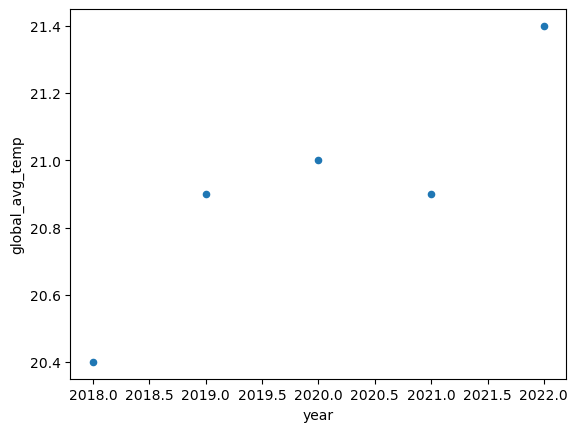

In [5]:
global_avg_temp_df.toPandas().plot.scatter(x='year', y='global_avg_temp')

we can see that the global average temperature is slightly increasing, however there is a downward trend in year 2021, which might be due to covid pandemic. The temperature increases slightly every year, but this doesn't give us the actual temperature variations because data on temperatures above oceans are not measured.

## Qn. 2. Correlation and population covariance between wind speed and air pressure.

In [6]:
corr_covar_df = weather_df.select(F.corr('wspd', 'pres'), F.covar_pop('wspd', 'pres'))

corr_covar_df.show()

+-------------------+---------------------+
|   corr(wspd, pres)|covar_pop(wspd, pres)|
+-------------------+---------------------+
|-0.1128079337787976|   -5.785491862972515|
+-------------------+---------------------+



correlation of -0.112 suggests that the wspd and pressure are slightly negatively correlated i.e. as wspd increases pressure slightly decreases and vice versa. Similarly covariance of -5.78 suggests the same.

## Qn. 3. Max temperature for each country in the month of July each year.

In [7]:
max_temp_july_df = weather_df\
                    .groupBy(F.year('date').alias('year'), F.month('date').alias('month'), 'country')\
                    .agg(F.max('tmax').alias('max_temp'))\
                    .filter('month == 7')\
                    .orderBy('country', 'year')

max_temp_july_df.show()

+----+-----+-------------+--------+
|year|month|      country|max_temp|
+----+-----+-------------+--------+
|2018|    7|     Abkhazia|    30.0|
|2019|    7|     Abkhazia|    29.9|
|2020|    7|     Abkhazia|    29.4|
|2021|    7|     Abkhazia|    31.0|
|2022|    7|     Abkhazia|    27.8|
|2018|    7|Aland Islands|    30.3|
|2019|    7|Aland Islands|    30.1|
|2020|    7|Aland Islands|    22.3|
|2021|    7|Aland Islands|    28.1|
|2022|    7|Aland Islands|    24.4|
|2018|    7|      Albania|    35.7|
|2019|    7|      Albania|    36.3|
|2020|    7|      Albania|    37.4|
|2021|    7|      Albania|    40.1|
|2022|    7|      Albania|    38.5|
|2018|    7|      Algeria|    35.7|
|2019|    7|      Algeria|    41.7|
|2020|    7|      Algeria|    36.7|
|2021|    7|      Algeria|    38.5|
|2022|    7|      Algeria|    36.3|
+----+-----+-------------+--------+
only showing top 20 rows



## Qn. 4. Standard deviation of max temperature for each country in the month of july each year.

In [8]:
# calculate the standard deviation for each country
stddev_max_temp_july_df = max_temp_july_df\
                            .groupBy('country')\
                            .agg(F.stddev('max_temp').alias('stddev'))\
                            .orderBy('country')\
                            .select('country',F.round('stddev', 1).alias('stddev_max_temp_july'))

stddev_max_temp_july_df.show()

+-------------------+--------------------+
|            country|stddev_max_temp_july|
+-------------------+--------------------+
|           Abkhazia|                 1.2|
|      Aland Islands|                 3.6|
|            Albania|                 1.8|
|            Algeria|                 2.4|
|     American Samoa|                 0.4|
|             Angola|                 1.2|
|           Anguilla|                 0.9|
|Antigua and Barbuda|                 0.4|
|          Argentina|                 2.6|
|              Aruba|                 0.9|
|            Austria|                 1.3|
|         Azerbaijan|                 2.5|
|            Bahamas|                 0.6|
|            Bahrain|                 1.2|
|         Bangladesh|                 0.8|
|           Barbados|                 0.8|
|            Belarus|                 2.4|
|            Belgium|                 5.1|
|            Bermuda|                 0.6|
|      Bouvet Island|                 0.6|
+----------

## Qn. 5. Min temperature that each country has ever had and the date at which it happened (window function)

In [9]:
window_spec = Window.partitionBy('country').orderBy('tmin')

ranked_df = weather_df.withColumn('dense_rn', F.dense_rank().over(window_spec)).filter('dense_rn == 1')

min_temp_df = ranked_df.select('date', 'country', col('tmin').alias('min_temp'))

min_temp_df.show()

+-------------------+--------------------+--------+
|               date|             country|min_temp|
+-------------------+--------------------+--------+
|2020-02-10 00:00:00|            Abkhazia|    -4.1|
|2019-01-08 00:00:00|             Albania|    -9.4|
|2019-01-08 00:00:00|             Algeria|    -0.3|
|2018-08-26 00:00:00|              Angola|    15.0|
|2018-03-13 00:00:00|            Anguilla|    19.6|
|2022-07-17 00:00:00|           Argentina|     1.9|
|2018-02-28 00:00:00|             Belgium|    -8.5|
|2021-09-03 00:00:00|British Virgin Is...|    19.6|
|2021-01-14 00:00:00|            Cambodia|    14.1|
|2018-12-24 00:00:00|                Chad|    10.8|
|2021-09-12 00:00:00|             Comoros|    13.1|
|2018-04-05 00:00:00|       Côte d'Ivoire|    11.8|
|2022-02-05 00:00:00|            Djibouti|    17.7|
|2021-01-24 00:00:00|            Dominica|    20.6|
|2021-02-21 00:00:00|            Dominica|    20.6|
|2021-03-12 00:00:00|            Dominica|    20.6|
|2021-03-20 

## Qn. 6. Find the 5 coldest days in Canada (use min avg temp) (Window Function)

In [10]:
window_spec = Window.partitionBy('country').orderBy('tavg')
ranked_df = weather_df\
                .withColumn('dense_rn', F.dense_rank().over(window_spec))\
                .filter('dense_rn <= 5')\
                .filter('country == "Canada"')

coldest_days_in_Canada_df = ranked_df.select('date', 'country', col('tavg').alias('avg_temperature'), col('dense_rn').alias('rank'))
coldest_days_in_Canada_df.show()

+-------------------+-------+---------------+----+
|               date|country|avg_temperature|rank|
+-------------------+-------+---------------+----+
|2022-01-21 00:00:00| Canada|          -24.2|   1|
|2018-01-01 00:00:00| Canada|          -23.5|   2|
|2022-01-22 00:00:00| Canada|          -23.5|   2|
|2018-01-06 00:00:00| Canada|          -22.9|   3|
|2022-01-15 00:00:00| Canada|          -22.3|   4|
|2018-01-05 00:00:00| Canada|          -22.2|   5|
+-------------------+-------+---------------+----+



## Qn. 7. Difference of each country’s average temperature from global average temperature for 2019.

In [11]:
avg_temp_df = weather_df\
                .filter(F.year('date') == 2019)\
                .groupBy('country')\
                .agg(F.mean('tavg').alias('avg_temp'))\
                .orderBy('country')

avg_temp_df.show()

global_avg_temp = round(weather_df.select(F.mean('tavg')).collect()[0][0], 1)
global_avg_temp # 20.9

diff_global_avg_temp_df = avg_temp_df\
                            .withColumn('year', F.lit(2019))\
                            .withColumn('avg_temp', F.round('avg_temp', 1))\
                            .withColumn('global_avg_temp', F.lit(global_avg_temp))\
                            .withColumn('difference', F.round(col('avg_temp') - col('global_avg_temp'), 1))

diff_global_avg_temp_df = diff_global_avg_temp_df.select('year', 'country', 'avg_temp', 'global_avg_temp', 'difference')

diff_global_avg_temp_df.show()

+-------------------+-------------------+
|            country|           avg_temp|
+-------------------+-------------------+
|           Abkhazia|  14.61452054794519|
|      Aland Islands|  7.079670329670329|
|            Albania|  16.56043956043955|
|            Algeria|  19.44136986301369|
|     American Samoa| 27.412054794520497|
|             Angola| 25.894794520547933|
|           Anguilla| 27.278904109589043|
|Antigua and Barbuda| 26.718630136986313|
|          Argentina|  17.93863013698628|
|              Aruba|  28.00821917808217|
|            Austria| 14.126373626373633|
|         Azerbaijan| 15.416164383561656|
|            Bahamas| 25.767582417582407|
|            Bahrain| 27.899999999999974|
|         Bangladesh| 26.225753424657544|
|           Barbados|  27.50328767123287|
|            Belarus|  9.316438356164383|
|            Belgium| 11.746703296703302|
|            Bermuda| 22.324725274725253|
|      Bouvet Island|-0.5103641456582632|
+-------------------+-------------

## Qn. 8. Rolling average of temperature in Belgium for the month of July 2019 (Window Function)

In [12]:
window_spec = Window.partitionBy('country').orderBy('date').rowsBetween(Window.unboundedPreceding, Window.currentRow)

belgium_july_2019_df = weather_df\
                        .filter(F.year('date') == 2019)\
                        .filter(F.month('date') == 7)\
                        .filter('country == "Belgium"')\
                        .withColumn('rolling_avg', F.mean('tavg').over(window_spec))\
                        .select('date', 'country', 'tavg', F.round('rolling_avg', 1).alias('rolling_avg'))

belgium_july_2019_df.show()

+-------------------+-------+----+-----------+
|               date|country|tavg|rolling_avg|
+-------------------+-------+----+-----------+
|2019-07-01 00:00:00|Belgium|18.6|       18.6|
|2019-07-02 00:00:00|Belgium|18.0|       18.3|
|2019-07-03 00:00:00|Belgium|17.2|       17.9|
|2019-07-04 00:00:00|Belgium|17.7|       17.9|
|2019-07-05 00:00:00|Belgium|19.7|       18.2|
|2019-07-06 00:00:00|Belgium|19.9|       18.5|
|2019-07-07 00:00:00|Belgium|16.9|       18.3|
|2019-07-08 00:00:00|Belgium|15.0|       17.9|
|2019-07-09 00:00:00|Belgium|16.3|       17.7|
|2019-07-10 00:00:00|Belgium|18.4|       17.8|
|2019-07-11 00:00:00|Belgium|20.3|       18.0|
|2019-07-12 00:00:00|Belgium|18.0|       18.0|
|2019-07-13 00:00:00|Belgium|17.4|       18.0|
|2019-07-14 00:00:00|Belgium|16.1|       17.8|
|2019-07-15 00:00:00|Belgium|15.0|       17.6|
|2019-07-16 00:00:00|Belgium|16.5|       17.6|
|2019-07-17 00:00:00|Belgium|18.6|       17.6|
|2019-07-18 00:00:00|Belgium|19.3|       17.7|
|2019-07-19 0

## Qn. 9. Find hottest and coldest day of UK for each month in 2020 (use tmin, tmax)

In [13]:
window_spec1 = Window.partitionBy('country', F.year('date'), F.month('date')).orderBy('tmin')
window_spec2 = Window.partitionBy('country', F.year('date'), F.month('date')).orderBy(F.desc('tmax'))

hottest_coldest_day_UK_df = weather_df\
        .filter('country == "United Kingdom"')\
        .filter(F.year('date') == 2020)\
        .withColumn('min_rank', F.dense_rank().over(window_spec1))\
        .withColumn('max_rank', F.dense_rank().over(window_spec2))\
        .withColumn('is_min_or_max', F.when(col('min_rank') == 1, F.lit('min')).when(col('max_rank') == 1, F.lit('max')))\
        .filter((col('min_rank') == 1) | (col('max_rank') == 1))\
        .select('date', 'country', 'tmin', 'tmax', 'is_min_or_max')

hottest_coldest_day_UK_df.show()

+-------------------+--------------+----+----+-------------+
|               date|       country|tmin|tmax|is_min_or_max|
+-------------------+--------------+----+----+-------------+
|2020-01-14 00:00:00|United Kingdom| 6.1|11.7|          max|
|2020-01-20 00:00:00|United Kingdom|-2.0| 6.0|          min|
|2020-02-16 00:00:00|United Kingdom| 4.9|12.3|          max|
|2020-02-28 00:00:00|United Kingdom| 0.3| 9.8|          min|
|2020-03-10 00:00:00|United Kingdom| 9.1|14.1|          max|
|2020-03-30 00:00:00|United Kingdom|-0.2| 6.3|          min|
|2020-04-11 00:00:00|United Kingdom| 9.0|22.5|          max|
|2020-04-01 00:00:00|United Kingdom|-0.9| 8.0|          min|
|2020-05-21 00:00:00|United Kingdom|13.1|24.6|          max|
|2020-05-12 00:00:00|United Kingdom| 1.7|11.8|          min|
|2020-05-14 00:00:00|United Kingdom| 1.7|10.6|          min|
|2020-06-25 00:00:00|United Kingdom|16.3|29.6|          max|
|2020-06-06 00:00:00|United Kingdom| 5.0|11.9|          min|
|2020-07-31 00:00:00|Uni

## Qn. 10. Fastest wind speed for USA and Canada each month of 2021 (pivot table)

In [14]:
pivoted_df = weather_df.groupBy(F.year('date'), F.month('date')).pivot('Country').max()
fastest_wspd_df = pivoted_df\
                    .where(col('year(date)') == 2021)\
                    .select(col('year(date)').alias('year'), col('month(date)').alias('month'), 'United States_max(wspd)', 'Canada_max(wspd)')\
                    .orderBy('month')
    
fastest_wspd_df.show()

22/11/04 12:46:35 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.
+----+-----+-----------------------+----------------+
|year|month|United States_max(wspd)|Canada_max(wspd)|
+----+-----+-----------------------+----------------+
|2021|    1|                   33.1|            20.2|
|2021|    2|                   27.0|            22.4|
|2021|    3|                   28.1|            26.4|
|2021|    4|                   33.5|            25.3|
|2021|    5|                   22.3|            20.9|
|2021|    6|                   18.4|            24.5|
|2021|    7|                   18.0|            17.5|
|2021|    8|                   20.2|            16.5|
|2021|    9|                   19.4|            16.4|
|2021|   10|                   23.8|            17.2|
|2021|   11|                   23.4|            22.5|
|2021|   12|                   26.6|            22.3|
+----+----

## Qn. 11. Lowest temperatures for each continent (join) and the country, date on which it was recorded.

In [15]:
join_expr = weather_df['country'] == continents_df['country']

joined_df = weather_df.join(F.broadcast(continents_df), join_expr) # since country dataset has a small size, we use broadcast join

window_spec = Window.partitionBy('continent').orderBy('tmin')

lowest_temp_continent_df = joined_df\
                            .withColumn('dense_rnk', F.dense_rank().over(window_spec))\
                            .filter('dense_rnk == 1')\
                            .select('continent', 'date', weather_df['country'], col('tmin').alias('min_temp'))

lowest_temp_continent_df.show()

+---------+-------------------+--------------------+--------+
|continent|               date|             country|min_temp|
+---------+-------------------+--------------------+--------+
|   Africa|2018-02-11 00:00:00|             Tunisia|    -6.9|
|   Europe|2022-02-22 00:00:00|Svalbard and Jan ...|   -30.7|
| Americas|2022-01-21 00:00:00|              Canada|   -31.7|
|     Asia|2018-01-23 00:00:00|          Kazakhstan|   -39.3|
|  Oceania|2018-05-15 00:00:00|Northern Mariana ...|    -0.5|
+---------+-------------------+--------------------+--------+

